# Lab. 2 - Análise Exploratória e Aprendizado Não-Supervisionado
### CMC-13 Introdução a Ciência de Dados

### Alunos:
- **João Pedro Couto Vieira**
- **Pedro de Oliveira Ramos**
- **Rafael Duarte Rocha**
- **Vinícius Ribeiro Rodrigues Camelo**

In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import seaborn as sns

df = pd.read_csv('./dataset_lab2.csv')
df['tibl'] = df['tibl']/10

## 1. Preparação dos Dados
Primeiramente, analisa-se o aspecto geral do dataset, visualizando todas as colunas e os tipos de dados presentes.

In [270]:
df.head()

,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw
0,0,8.078,6.68,7.201,4.88,4.181,3.70,0.550,4.03,3.870,3.84
1,1,8.891,6.63,8.053,5.59,4.704,4.30,8.022,4.51,4.150,4.01
2,2,7.997,6.37,6.926,5.28,4.307,3.90,7.535,4.04,3.831,3.34
3,3,7.765,5.70,6.576,4.77,4.004,3.52,6.917,3.40,3.578,3.41
4,4,6.280,4.84,5.209,3.73,3.395,2.72,5.627,2.96,3.188,3.13


Vamos avaliar a presença de valores nulos e a distribuição dos dados em cada coluna.

In [271]:
print(df.isnull().sum())

id       0
huml     1
humw     1
ulnal    3
ulnaw    2
feml     2
femw     1
tibl     2
tibw     1
tarl     1
tarw     1
dtype: int64


Vemos que algumas features não apresentam todos os valores. Temos duas possibilidades para lidar com isso: 
1. remover as linhas com valores nulos ou;
2. preencher esses valores com a média ou mediana da coluna.

Como estamos lidando com poucos dados faltantes, podemos simplesmente desconisderar essas linhas. A segunda opção traria informações a mais para o modelo

In [272]:
df.dropna(inplace=True)
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)

## Análise Exploratória

Vamos avaliar a distribuição de cada feature, a fim de entender melhor o dataset.

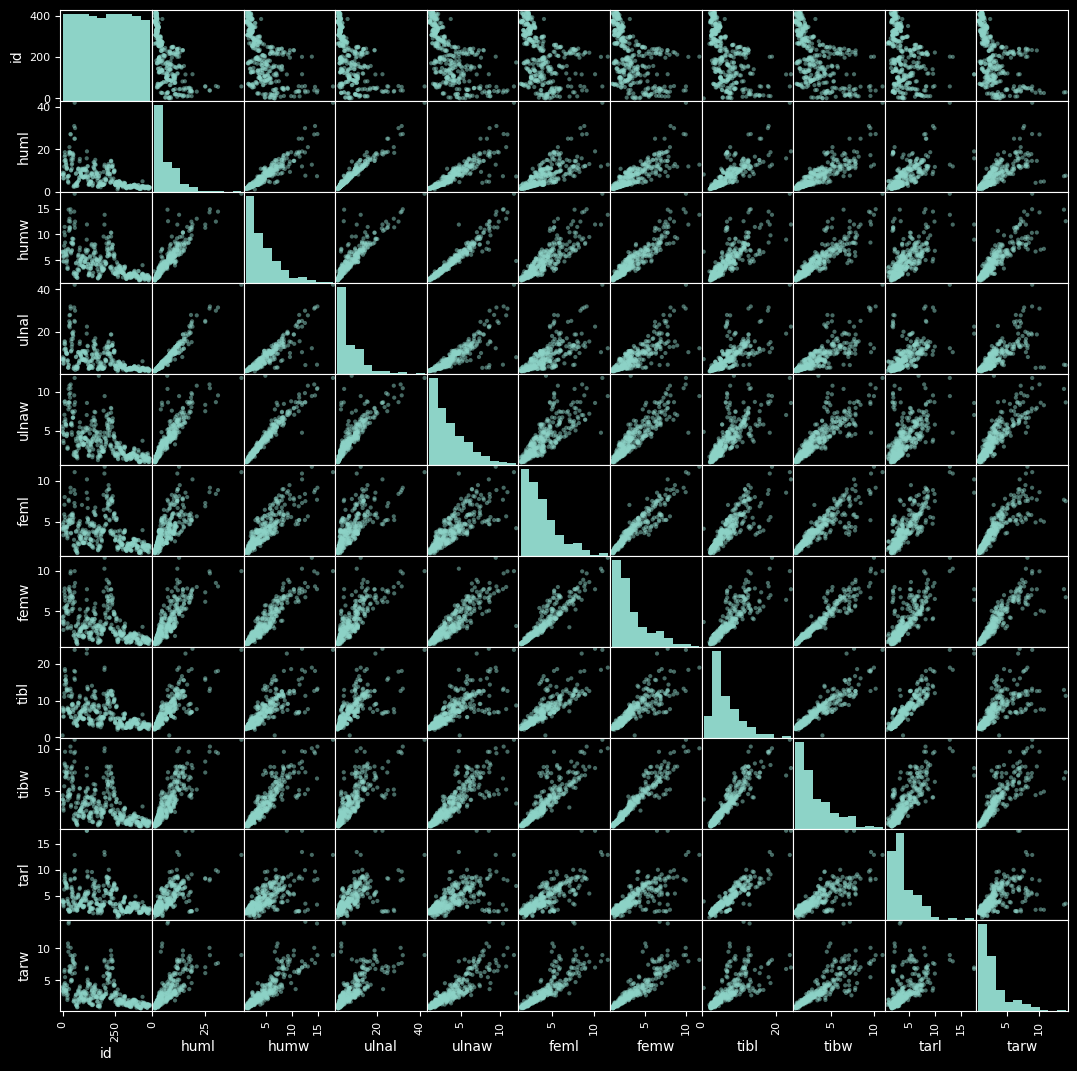

In [273]:
# Criando matriz de dispersão
scatter_matrix(df, alpha=0.5, figsize=(13, 13), diagonal='hist')
plt.show()

Uma coisa que conseguimos perceber com a scatter matrix é que os dados (com exceção da coluna id) aparentam ter uma correlação linear muito evidente. 

Como consequência, podemos perceber que o uso de todas as variáveis explicativas pode representar um problema dimensional (catastrofe de dimensionalidade), bem como o valor agregado de uma nova variável explicativa pode ser baixo.

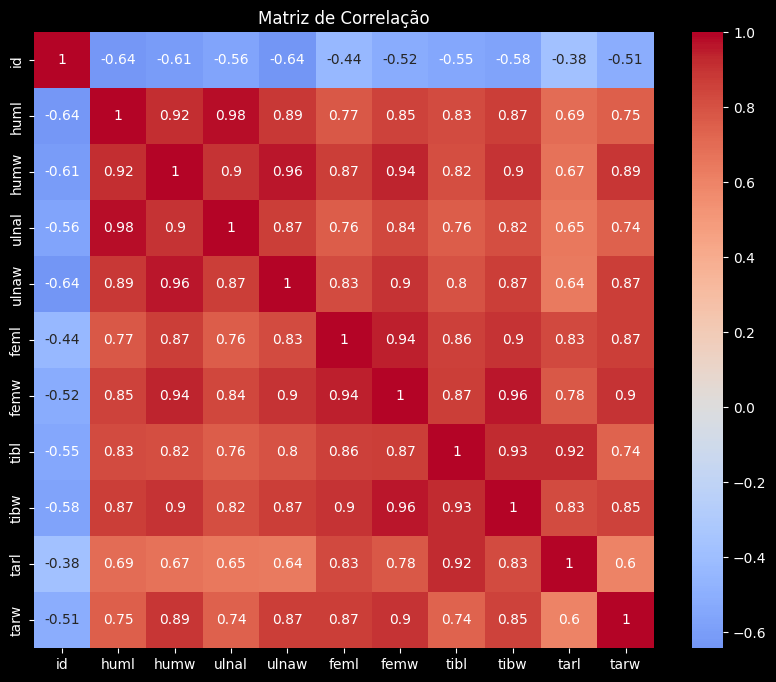

In [274]:
# Vamos avaliar a matriz de correlações

correlation_matrix = df.corr()

# Plotar um heatmap da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

De fato comprovamos a hipótese de que as variáveis explicativas são altamente correlacionadas.

Variáveis com alta correlação podem ser redundantes. Por exemplo, se `ulnal` e `huml` têm uma correlação de 0.98

Podemos considerar, portanto, a possibilidade de reduzir a dimensionalidade do problema, utilizando técnicas de redução de dimensionalidade (como PCA). Porém faremos de uma maneira mais simples (Navalha de Okcham), manteremos as variáveis com menor correlação média entre si.

In [275]:
# Vamos calcular a correlação média de cada variável com as outras (média aritmética das correlações)
print(correlation_matrix.abs().mean().sort_values(ascending=True))

id       0.584070
tarl     0.727376
tarw     0.793132
ulnal    0.807136
tibl     0.824600
feml     0.825281
huml     0.834616
ulnaw    0.841716
humw     0.861846
femw     0.863204
tibw     0.864448
dtype: float64


Vamos manter as 5 variáveis com menor correlação média
* `tarl`     0.728581
* `tarw`     0.793887
* `ulnal`    0.807426
* `tibl`     0.824674
* `feml`     0.825225

In [276]:
df_treated = df[['id', 'tarl', 'tarw', 'ulnal', 'tibl', 'feml']]
df_treated.head()

,id,tarl,tarw,ulnal,tibl,feml
0,0,3.870,3.84,7.201,0.550,4.181
1,1,4.150,4.01,8.053,8.022,4.704
2,2,3.831,3.34,6.926,7.535,4.307
3,3,3.578,3.41,6.576,6.917,4.004
4,4,3.188,3.13,5.209,5.627,3.395


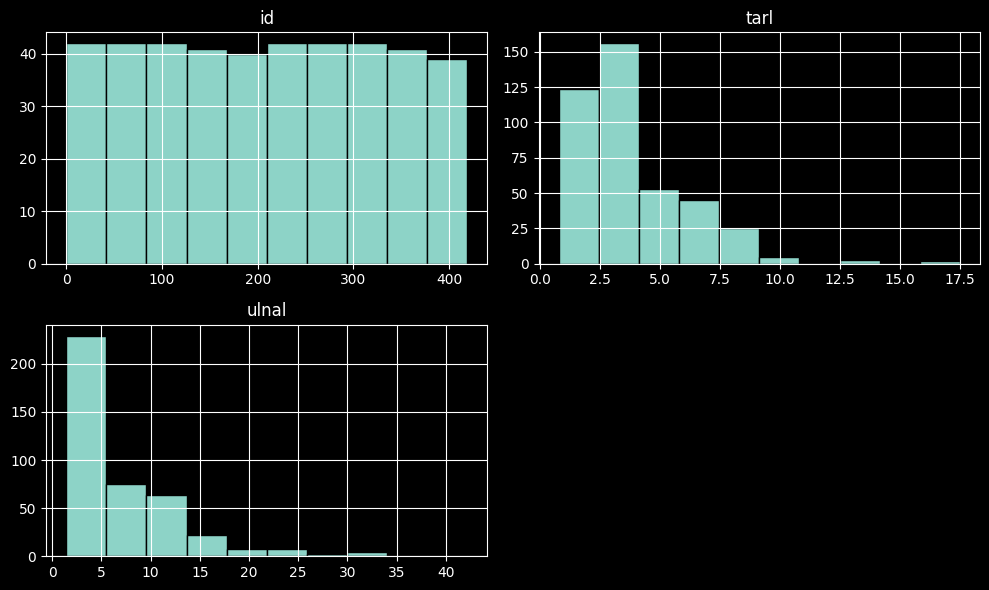

In [277]:
# Plotar histogramas para cada coluna
df_treated[['id','tarl','ulnal']].hist(bins=10, figsize=(10, 6), edgecolor='black')

# Ajustar layout
plt.tight_layout()
plt.show()

In [278]:
def min_max_normalize(df):
    """
    Normalize specified columns of a DataFrame using Min-Max normalization.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data to be normalized

    Returns:
    pd.DataFrame: DataFrame with normalized columns
    """
    df_normalized = df.copy()
    for column in df_normalized.columns:
        min_value = df_normalized[column].min()
        max_value = df_normalized[column].max()
        df_normalized[column] = (df_normalized[column] - min_value) / (max_value - min_value)
    return df_normalized

# retirando a coluna ID
df_treated.drop(columns=['id'],axis=1,inplace=True)

# Normalizando todas as colunas do df_treated
df_normalizado = min_max_normalize(df_treated)
df_normalizado.head()

/var/folders/j3/85v9zb655rq94y5l71nq78nm0000gn/T/ipykernel_99496/1046085602.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treated.drop(columns=['id'],axis=1,inplace=True)


,tarl,tarw,ulnal,tibl,feml
0,0.184955,0.236783,0.141992,0.000000,0.284873
1,0.201698,0.249442,0.162879,0.318635,0.334569
2,0.182623,0.199553,0.135250,0.297868,0.296845
3,0.167494,0.204765,0.126670,0.271514,0.268054
4,0.144173,0.183917,0.093158,0.216503,0.210186


Vamos fazer o tratamento com o k-means rodando com 2, 3, 6 e 9 clusteres

In [279]:
# dataframe para armazenar os valores do kmeans
df_aprendizado = pd.DataFrame(df)

# Aplicando K-MEANS com 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=50)
df_aprendizado['Cluster_2'] = kmeans_2.fit_predict(df)

# Aplicando K-MEANS com 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=50)
df_aprendizado['Cluster_3'] = kmeans_3.fit_predict(df)

# Aplicando K-MEANS com 6 clusters
kmeans_6 = KMeans(n_clusters=6, random_state=50)
df_aprendizado['Cluster_6'] = kmeans_6.fit_predict(df)

# Aplicando K-MEANS com 9 clusters
kmeans_9 = KMeans(n_clusters=9, random_state=50)
df_aprendizado['Cluster_9'] = kmeans_9.fit_predict(df)

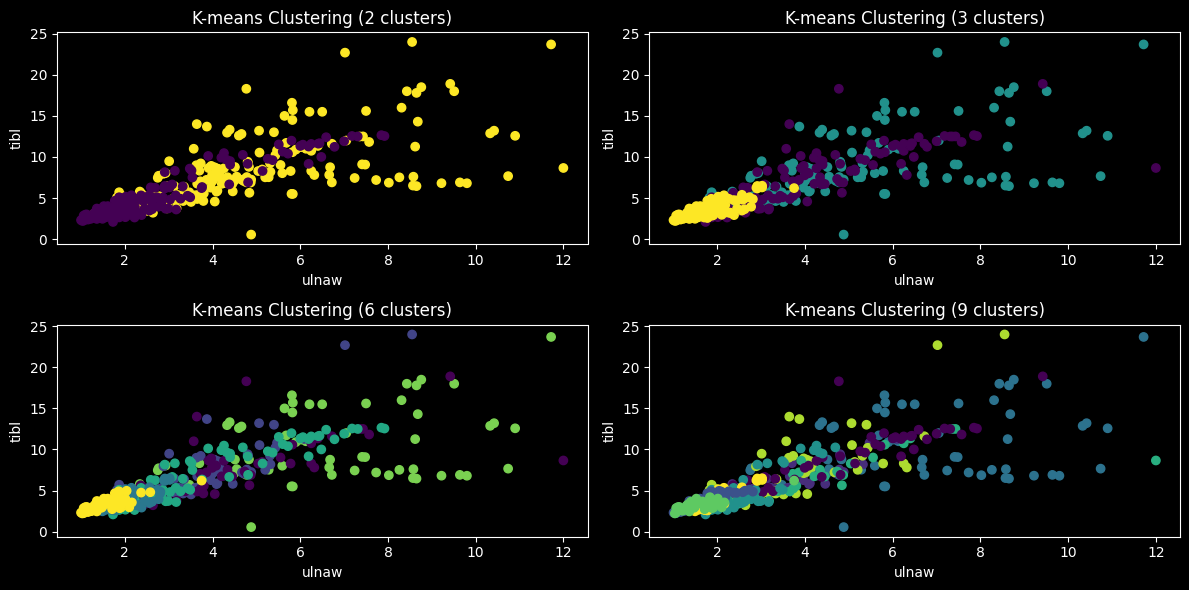

In [283]:
plt.figure(figsize=(12, 6))

# Plotting K-means with 2 clusters
plt.subplot(2, 2, 1)
plt.scatter(df_aprendizado['ulnaw'], df_aprendizado['tibl'], c=df_aprendizado['Cluster_2'], cmap='viridis')
plt.title('K-means Clustering (2 clusters)')
plt.xlabel('ulnaw')
plt.ylabel('tibl')

# Plotting K-means with 3 clusters
plt.subplot(2, 2, 2)
plt.scatter(df_aprendizado['ulnaw'], df_aprendizado['tibl'], c=df_aprendizado['Cluster_3'], cmap='viridis')
plt.title('K-means Clustering (3 clusters)')
plt.xlabel('ulnaw')
plt.ylabel('tibl')

# Plotting K-means with 6 clusters
plt.subplot(2, 2, 3)
plt.scatter(df_aprendizado['ulnaw'], df_aprendizado['tibl'], c=df_aprendizado['Cluster_6'], cmap='viridis')
plt.title('K-means Clustering (6 clusters)')
plt.xlabel('ulnaw')
plt.ylabel('tibl')

# Plotting K-means with 9 clusters
plt.subplot(2, 2, 4)
plt.scatter(df_aprendizado['ulnaw'], df_aprendizado['tibl'], c=df_aprendizado['Cluster_9'], cmap='viridis')
plt.title('K-means Clustering (9 clusters)')
plt.xlabel('ulnaw')
plt.ylabel('tibl')

plt.tight_layout()
plt.show()


Agora que fizemos algumas simulações, vamos fazer o Elbow Test para avaliar qual o melhor número de clusteres para o kmeans

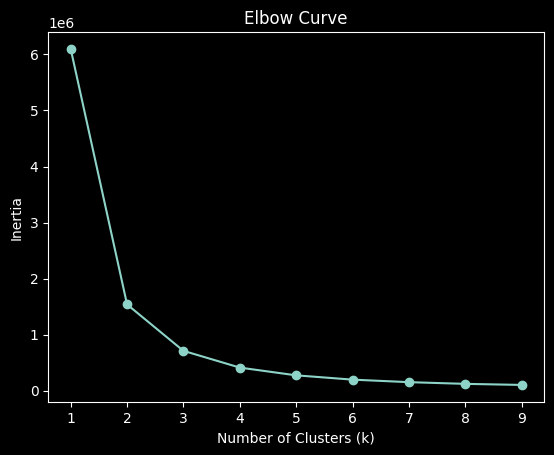

In [282]:
import numpy as np

# Define a range of k values
k_values = range(1, 10)

# Initialize an empty list to store the inertia values
inertia_values = []

# Perform KMeans clustering for each k value and calculate the inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=50)
    kmeans.fit(df)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()


Diante dos dados avaliados, percebemos que a melhor escolha para a quantidade de clusteres é 3, pelo critério do cotovelo 